<a href="https://colab.research.google.com/github/vytsb/Gilusis_Mokymas/blob/main/lab1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pirminis apdorojimas, funkcijos, importai

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from contractions import contractions
from sklearn.model_selection import StratifiedKFold


In [27]:
raw = pd.read_csv("IMDB Dataset.csv")


In [28]:
def count_symbols(row):
    result = pd.Series(list(row)).value_counts()
    return result

char_counts = raw["review"].apply(count_symbols)

unexpected = []
for x in char_counts.columns:
    if x not in string.printable:
        unexpected.append(x)

char_counts[unexpected].dropna(how='all').index

rows_to_drop = char_counts[unexpected].dropna(how='all').index

filtered = raw.drop(rows_to_drop)
filtered['sentiment'].value_counts()

,count
sentiment,
positive,22868
negative,22470


In [29]:
pattern = r"\w+"   # "<\w+\s?/\s?>"

filtered['tokens'] = filtered['review'].apply(lambda x: re.findall(pattern, x))
filtered["label"] = filtered["sentiment"].replace({"positive": 1, "negative": 0})


<ipython-input-29-108355b5bf23>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered["label"] = filtered["sentiment"].replace({"positive": 1, "negative": 0})


In [30]:
train, test = train_test_split(filtered, test_size=0.3, random_state=420, stratify=filtered["label"])
train['label'].value_counts(), test['label'].value_counts()

(label
 1    16007
 0    15729
 Name: count, dtype: int64,
 label
 1    6861
 0    6741
 Name: count, dtype: int64)

In [31]:
train_x = train[['tokens']]
train_y = train['label']
test_x, test_y = test[['tokens']], test['label']

In [32]:
def naive_bayes_prediction(train_x, train_y, test_x, token_col):
    # calculate prior class probabilities
    prior_pos = len(train_y[train_y==1]) / len(train_x)
    prior_neg = len(train_y[train_y==0]) / len(train_x)

    # calculate vocabulary size
    vocabulary_size = len(set([x for y in train_x[token_col].to_list() for x in y]))

    pos = train_x[train_y==1][token_col]
    neg = train_x[train_y==0][token_col]

    # count words in total in positive and negative classes
    word_count_positive = pos.str.len().sum()
    word_count_negative = neg.str.len().sum()

    # count each word in positive and negative classes
    # (optional) count zero counts for words which are present in one class to another class
    each_word_count_positive = pd.Series([x for y in pos.to_list() for x in y]).value_counts()
    each_word_count_negative = pd.Series([x for y in neg.to_list() for x in y]).value_counts()

    not_in_negative = []
    for word in each_word_count_positive.index:
        if word not in each_word_count_negative.index:
            not_in_negative.append(word)

    not_in_positive = [x for x in each_word_count_negative.index
                       if x not in each_word_count_positive.index]

    not_in_neg_zeros = pd.Series(index=not_in_negative, data=0)
    not_in_pos_zeros = pd.Series(index=not_in_positive, data=0)

    each_word_count_positive = pd.concat([each_word_count_positive, not_in_pos_zeros])
    each_word_count_negative = pd.concat([each_word_count_negative, not_in_neg_zeros])

    # get likelihoods for each word in both classes
    likelihood_positive = (each_word_count_positive + 1) / (word_count_positive + vocabulary_size)
    likelihood_negative = (each_word_count_negative + 1) / (word_count_negative + vocabulary_size)

    # calculate probabilites of each class for test sentences
    predictions = []
    for sentence in tqdm(test_x[token_col].to_list()):

        positive_prob = 1
        negative_prob = 1

        for word in sentence:
            if word not in likelihood_positive.index:
                continue
            result_pos = likelihood_positive[word]
            positive_prob *= result_pos
            result_neg = likelihood_negative[word]
            negative_prob *= result_neg

        predicted_class = np.argmax([negative_prob, positive_prob])
        predictions.append(predicted_class)

    return predictions

In [33]:
preds = naive_bayes_prediction(train_x, train_y, test_x, 'tokens')
preds[:20]  # pirmi 20 spėjimai

100%|██████████| 13602/13602 [00:22<00:00, 599.82it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

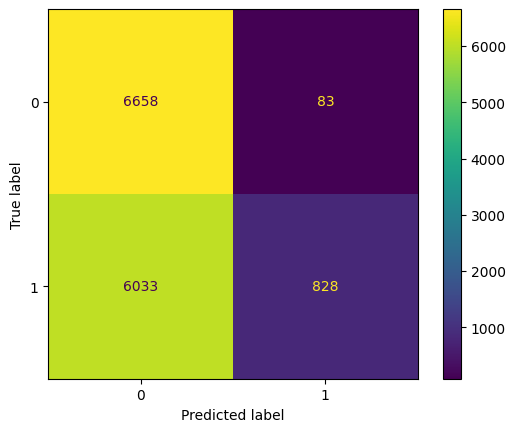

Accuracy: 0.55
Precision: 0.91
Recall: 0.12
F1: 0.21


In [34]:
def print_metrics(test_y, preds):
  c_mat = confusion_matrix(test_y, preds)
  viz = ConfusionMatrixDisplay(c_mat)
  viz.plot()
  plt.show()
  tp = c_mat[1, 1]
  tn = c_mat[0, 0]
  fp = c_mat[0, 1]
  fn = c_mat[1, 0]
  accuracy = (tp + tn) / len(preds)
  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  f1 = 2 * precision * recall / (precision + recall)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1: {f1:.2f}')

print_metrics(test_y, preds)

In [35]:
pattern = r"\w+'?\w*"


filtered['tokens_2'] = filtered['review'].apply(lambda x: re.findall(pattern, x.lower()))
filtered

,review,sentiment,tokens,label,tokens_2
0,One of the other reviewers has mentioned that ...,positive,"[One, of, the, other, reviewers, has, mentione...",1,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,"[A, wonderful, little, production, br, br, The...",1,"[a, wonderful, little, production, br, br, the..."
2,I thought this was a wonderful way to spend ti...,positive,"[I, thought, this, was, a, wonderful, way, to,...",1,"[i, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,"[Basically, there, s, a, family, where, a, lit...",0,"[basically, there's, a, family, where, a, litt..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, s, Love, in, the, Time, of, M...",1,"[petter, mattei's, love, in, the, time, of, mo..."
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,"[I, thought, this, movie, did, a, down, right,...",1,"[i, thought, this, movie, did, a, down, right,..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"[Bad, plot, bad, dialogue, bad, acting, idioti...",0,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,I am a Catholic taught in parochial elementary...,negative,"[I, am, a, Catholic, taught, in, parochial, el...",0,"[i, am, a, catholic, taught, in, parochial, el..."
49998,I'm going to have to disagree with the previou...,negative,"[I, m, going, to, have, to, disagree, with, th...",0,"[i'm, going, to, have, to, disagree, with, the..."


100%|██████████| 13602/13602 [00:21<00:00, 639.26it/s]


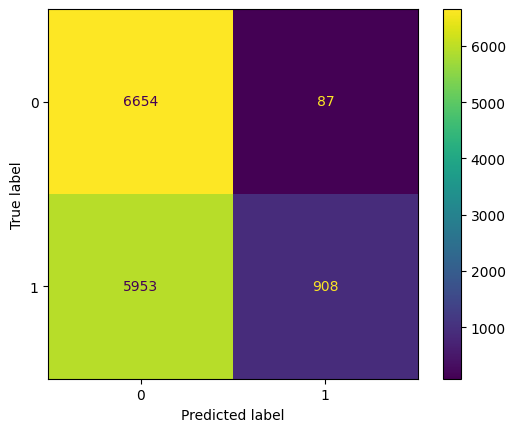

Accuracy: 0.56
Precision: 0.91
Recall: 0.13
F1: 0.23


In [36]:
def split_and_train(data, token_col):
  train, test = train_test_split(data, test_size=0.3, random_state=420, stratify=data["label"])
  train_x = train[[token_col]]
  train_y = train['label']
  test_x, test_y = test[[token_col]], test['label']
  preds = naive_bayes_prediction(train_x, train_y, test_x, token_col)
  print_metrics(test_y, preds)

split_and_train(filtered, 'tokens_2')

In [37]:
contractions_lower = {}

for k, v in contractions.items():
  contractions_lower[k.lower()] = v.lower()

In [38]:
pattern = r"\w+'?\w*"


filtered['review_2'] = filtered['review'].str.lower().replace(contractions_lower, regex=True)
filtered['tokens_2'] = filtered['review_2'].apply(lambda x: re.findall(pattern, x.lower()))
filtered

,review,sentiment,tokens,label,tokens_2,review_2
0,One of the other reviewers has mentioned that ...,positive,"[One, of, the, other, reviewers, has, mentione...",1,"[one, of, the, other, reviewers, has, mentione...",one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,"[A, wonderful, little, production, br, br, The...",1,"[a, wonderful, little, production, br, br, the...",a wonderful little production. <br /><br />the...
2,I thought this was a wonderful way to spend ti...,positive,"[I, thought, this, was, a, wonderful, way, to,...",1,"[i, thought, this, was, a, wonderful, way, to,...",i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,"[Basically, there, s, a, family, where, a, lit...",0,"[basically, there, is, a, family, where, a, li...",basically there is a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, s, Love, in, the, Time, of, M...",1,"[petter, mattei's, love, in, the, time, of, mo...","petter mattei's ""love in the time of money"" is..."
...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,"[I, thought, this, movie, did, a, down, right,...",1,"[i, thought, this, movie, did, a, down, right,...",i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"[Bad, plot, bad, dialogue, bad, acting, idioti...",0,"[bad, plot, bad, dialogue, bad, acting, idioti...","bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,"[I, am, a, Catholic, taught, in, parochial, el...",0,"[i, am, a, catholic, taught, in, parochial, el...",i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,"[I, m, going, to, have, to, disagree, with, th...",0,"[i, am, going, to, have, to, disagree, with, t...",i am going to have to disagree with the previo...


100%|██████████| 13602/13602 [00:19<00:00, 684.39it/s]


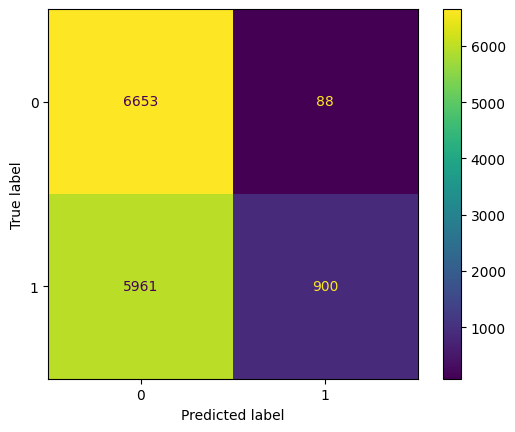

Accuracy: 0.56
Precision: 0.91
Recall: 0.13
F1: 0.23


In [39]:
split_and_train(filtered, 'tokens_2')

In [40]:
stopwords = pd.read_csv('stopwords.txt', header=None)[0].str.lower().tolist()
stopwords.append('br')


In [41]:
pattern = r"\w+'?\w*"

filtered['review_2'] = (filtered['review'].str.lower()
                        .replace(contractions_lower, regex=True))
filtered['tokens_3'] = filtered['review_2'].apply(lambda x: re.findall(pattern, x.lower()))

In [42]:
filtered['tokens_3'] = filtered['tokens_3'].apply(
    lambda x: [y for y in x if y not in stopwords]
    )
filtered

,review,sentiment,tokens,label,tokens_2,review_2,tokens_3
0,One of the other reviewers has mentioned that ...,positive,"[One, of, the, other, reviewers, has, mentione...",1,"[one, of, the, other, reviewers, has, mentione...",one of the other reviewers has mentioned that ...,"[reviewers, mentioned, watching, 1, oz, episod..."
1,A wonderful little production. <br /><br />The...,positive,"[A, wonderful, little, production, br, br, The...",1,"[a, wonderful, little, production, br, br, the...",a wonderful little production. <br /><br />the...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[I, thought, this, was, a, wonderful, way, to,...",1,"[i, thought, this, was, a, wonderful, way, to,...",i thought this was a wonderful way to spend ti...,"[wonderful, spend, time, hot, summer, weekend,..."
3,Basically there's a family where a little boy ...,negative,"[Basically, there, s, a, family, where, a, lit...",0,"[basically, there, is, a, family, where, a, li...",basically there is a family where a little boy...,"[basically, family, little, boy, jake, zombie,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, s, Love, in, the, Time, of, M...",1,"[petter, mattei's, love, in, the, time, of, mo...","petter mattei's ""love in the time of money"" is...","[petter, mattei's, love, time, money, visually..."
...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,"[I, thought, this, movie, did, a, down, right,...",1,"[i, thought, this, movie, did, a, down, right,...",i thought this movie did a down right good job...,"[movie, job, creative, original, expecting, lo..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"[Bad, plot, bad, dialogue, bad, acting, idioti...",0,"[bad, plot, bad, dialogue, bad, acting, idioti...","bad plot, bad dialogue, bad acting, idiotic di...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,I am a Catholic taught in parochial elementary...,negative,"[I, am, a, Catholic, taught, in, parochial, el...",0,"[i, am, a, catholic, taught, in, parochial, el...",i am a catholic taught in parochial elementary...,"[am, catholic, taught, parochial, elementary, ..."
49998,I'm going to have to disagree with the previou...,negative,"[I, m, going, to, have, to, disagree, with, th...",0,"[i, am, going, to, have, to, disagree, with, t...",i am going to have to disagree with the previo...,"[am, disagree, previous, comment, maltin, rate..."


100%|██████████| 13602/13602 [00:08<00:00, 1611.88it/s]


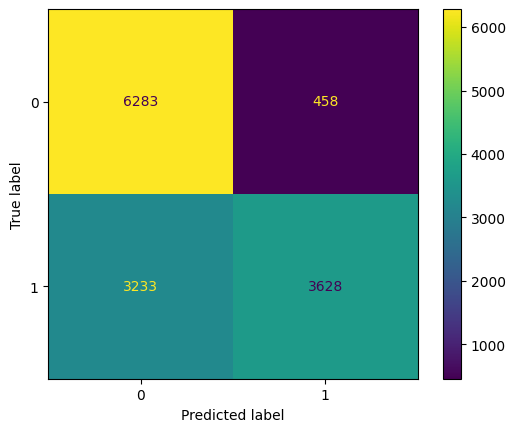

Accuracy: 0.73
Precision: 0.89
Recall: 0.53
F1: 0.66


In [43]:
split_and_train(filtered, 'tokens_3')

100%|██████████| 9068/9068 [00:06<00:00, 1344.84it/s]


--------------------


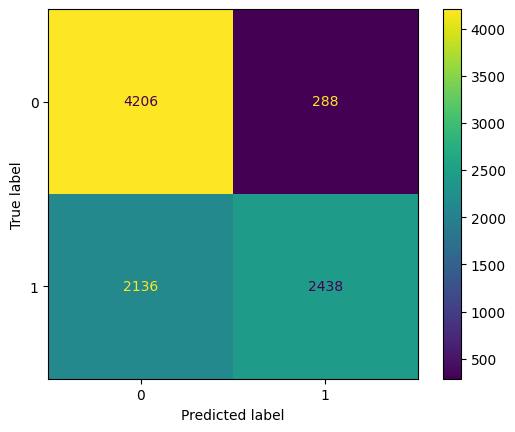

Accuracy: 0.73
Precision: 0.89
Recall: 0.53
F1: 0.67


100%|██████████| 9068/9068 [00:04<00:00, 1875.05it/s]


--------------------


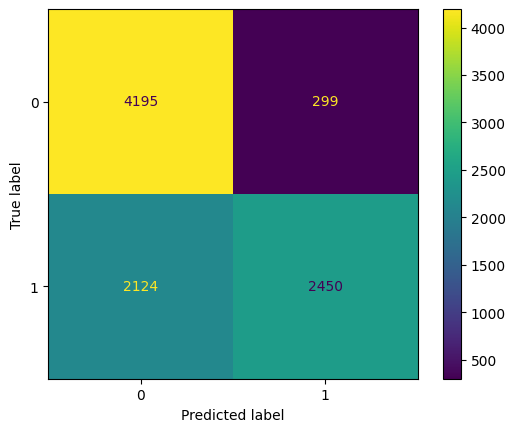

Accuracy: 0.73
Precision: 0.89
Recall: 0.54
F1: 0.67


100%|██████████| 9068/9068 [00:06<00:00, 1492.33it/s]


--------------------


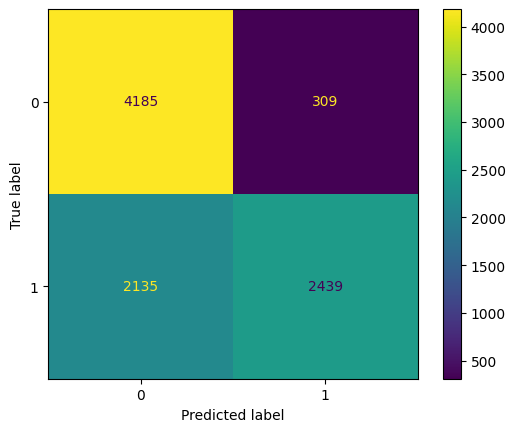

Accuracy: 0.73
Precision: 0.89
Recall: 0.53
F1: 0.67


100%|██████████| 9067/9067 [00:04<00:00, 1823.91it/s]


--------------------


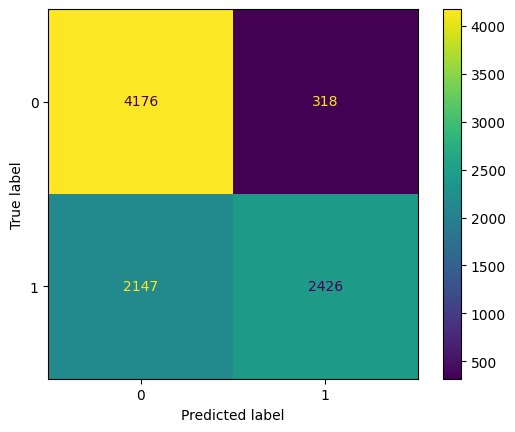

Accuracy: 0.73
Precision: 0.88
Recall: 0.53
F1: 0.66


100%|██████████| 9067/9067 [00:06<00:00, 1474.56it/s]


--------------------


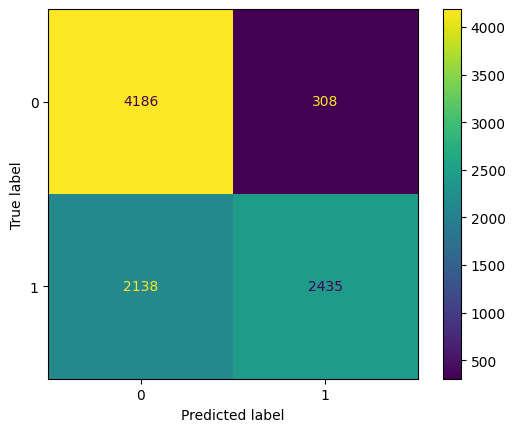

Accuracy: 0.73
Precision: 0.89
Recall: 0.53
F1: 0.67


In [44]:

kfold = StratifiedKFold(5, shuffle=True, random_state=21)

for train_index, test_index in kfold.split(filtered[['tokens_3']], filtered['label']):
  train_x = filtered.iloc[train_index][['tokens_3']]
  test_x = filtered.iloc[test_index][['tokens_3']]
  train_y = filtered.iloc[train_index]['label']
  test_y = filtered.iloc[test_index]['label']

  preds = naive_bayes_prediction(train_x, train_y, test_x, 'tokens_3')
  print('-' * 20)
  print_metrics(test_y, preds)


## Papildomi apdorojimo būdai


100%|██████████| 9068/9068 [00:05<00:00, 1789.58it/s]


--------------------


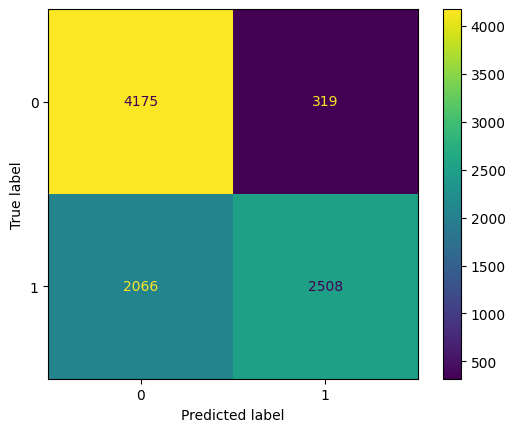

Accuracy: 0.74
Precision: 0.89
Recall: 0.55
F1: 0.68


100%|██████████| 9068/9068 [00:05<00:00, 1796.85it/s]


--------------------


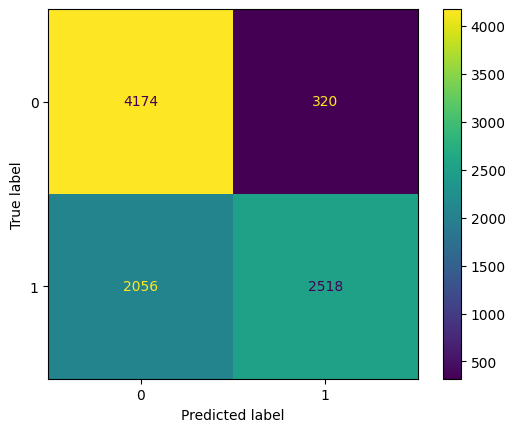

Accuracy: 0.74
Precision: 0.89
Recall: 0.55
F1: 0.68


100%|██████████| 9068/9068 [00:06<00:00, 1457.78it/s]


--------------------


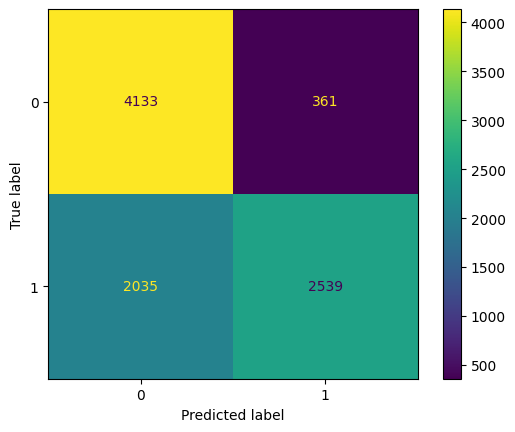

Accuracy: 0.74
Precision: 0.88
Recall: 0.56
F1: 0.68


100%|██████████| 9067/9067 [00:04<00:00, 1841.91it/s]


--------------------


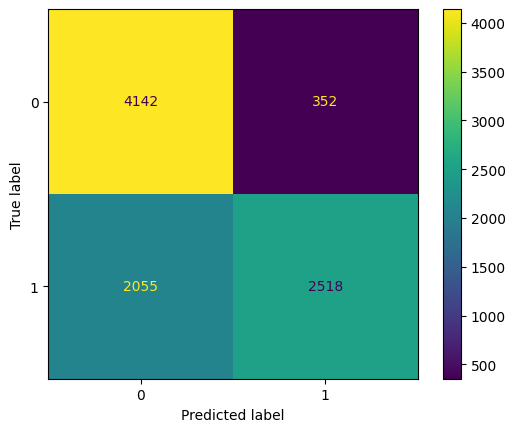

Accuracy: 0.73
Precision: 0.88
Recall: 0.55
F1: 0.68


100%|██████████| 9067/9067 [00:06<00:00, 1452.33it/s]


--------------------


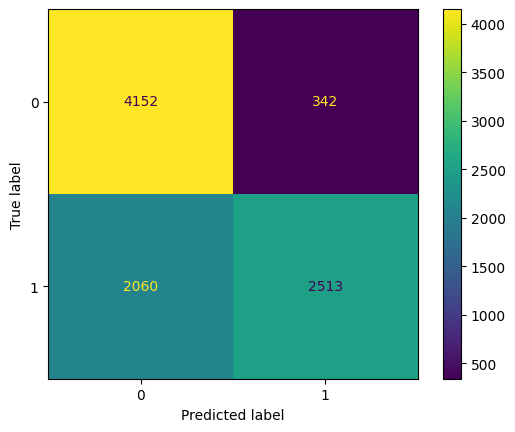

Accuracy: 0.74
Precision: 0.88
Recall: 0.55
F1: 0.68


In [47]:
#STOPWORDS.TXT pakeistas, pridėta daugiau žodžių

# naujas duomenų apdorojimo būdas nr. 1 - pašalinti tokenai su skaičiais
def remove_numbers(tokens):
    return [token for token in tokens if not any(char.isdigit() for char in token)]

filtered['tokens_4'] = filtered['tokens_3'].apply(remove_numbers)

# naujas duomenų apdorojimo būdas nr. 2 - "sukamieninti" žodžiai pašalinant dažniausiai pasitaikančias galūnes

def stemmer(tokens):
    suffixes = ('ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment')
    new_tokens = []
    for token in tokens:
        for suffix in suffixes:
            if token.endswith(suffix) and len(token) > len(suffix) + 2:
                token = token[:-len(suffix)]
                break
        new_tokens.append(token)
    return new_tokens

filtered['tokens_5'] = filtered['tokens_4'].apply(stemmer)

# naujas duomenų apdorojimo būdas nr. 3 - apjungia neiginius. pvz: jei tokenai yra "not" ir po jo "bad", tai padaromas tokenas "not_bad"
def join_negations(tokens):
    negation_words = {'not', 'no', 'never'}
    transformed_tokens = []
    skip_next = False
    for i, token in enumerate(tokens):
        if skip_next:
            skip_next = False
            continue
        if token in negation_words and i + 1 < len(tokens):
            combined_token = token + '_' + tokens[i + 1]
            transformed_tokens.append(combined_token)
            skip_next = True  # Praleidžiam sekantį, nes jau apjungtas
        else:
            transformed_tokens.append(token)
    return transformed_tokens

filtered['tokens_6'] = filtered['tokens_5'].apply(join_negations)

# naujas duomenų apdorojimo būdas nr. 4 - normalizuoja tokenus su pasikratojančiomis raidėmis. pvz "gooooood" padaro į "good"
def normalize_repeated(tokens):
    pattern = re.compile(r'(.)\1{2,}')  # suveikia jei simbolis pakartotas daugiau nei 2kartus.
    normalized_tokens = [pattern.sub(r'\1\1', token) for token in tokens] # palieka tokene tik 2 pasikartojančias raides
    return normalized_tokens

filtered['tokens_7'] = filtered['tokens_6'].apply(normalize_repeated)


# paleidžiamas stratified K fold su naujai apdorotais duomenimis
kfold = StratifiedKFold(5, shuffle=True, random_state=21)

for train_index, test_index in kfold.split(filtered[['tokens_7']], filtered['label']):
    train_x = filtered.iloc[train_index][['tokens_7']]
    test_x = filtered.iloc[test_index][['tokens_7']]
    train_y = filtered.iloc[train_index]['label']
    test_y = filtered.iloc[test_index]['label']

    preds = naive_bayes_prediction(train_x, train_y, test_x, 'tokens_7')
    print('-' * 20)
    print_metrics(test_y, preds)
